In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from utils import * 

(-21.22803, 23.509629999999998, -20.875552267539256, 42.875552267539256)

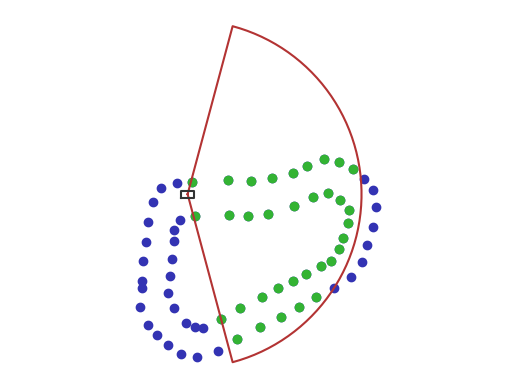

In [2]:
""" Parameters """
parameters = yaml.load(open('parameters.yaml', 'r'), Loader=yaml.FullLoader)

""" Load track """
track = yaml.load(open('trackdrive.yaml', 'r'), Loader=yaml.FullLoader)
cones = track['cones']
blue = cones['blue']
yellow = cones['yellow']
all_cones = np.concatenate((blue, yellow), axis=0)
initial_pose = np.array([
    track['initial_pose']['x'],
    track['initial_pose']['y'],
    track['initial_pose']['yaw'],
])

# Homogenous coordinates for colorless cones
cones = homogenize(all_cones)

plot_cones(all_cones)
plot_cones(get_visible_cones(cones, initial_pose, p=parameters), color=(0.2,0.7,0.2))
plot_fov(initial_pose, p=parameters)
plot_car(initial_pose, p=parameters)
plt.axis('equal')
plt.axis('off')